# FTP NOAA

## Get AR IDs

In [1]:
from ftplib import FTP
from sunpy.io.special import srs

from module import toSunpyMap

In [2]:

file = 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-14/imoa_03933_l2_20240714_09011769_emi1.fts.bz2'
#'data/L1/imoa_06563_l1_20240317_12440670_emi1.fts.bz2'

In [4]:
map = toSunpyMap(file, center_disk=True)

In [5]:
latest = '/pub/latest/SRS.txt'


filename = 'pub/warehouse/' + str(map.date.datetime.year) + '/SRS/' + map.date.strftime("%Y%m%d") + 'SRS.txt'

with FTP("ftp.swpc.noaa.gov") as ftp:
    ftp.login()
    
    file_contents = []
    ftp.retrlines('RETR '+filename, file_contents.append)
    
    header, section_lines, supplementary_lines = srs.split_lines(file_contents)

    srs_table = srs.make_table(header, section_lines, supplementary_lines)

In [6]:
file_contents

[':Product: 0714SRS.txt',
 ':Issued: 2024 Jul 14 0110 UTC',
 '# Prepared jointly by the U.S. Dept. of Commerce, NOAA,',
 '# Space Weather Prediction Center and the U.S. Air Force.',
 '#',
 'Joint USAF/NOAA Solar Region Summary',
 'SRS Number 196 Issued at 0030Z on 14 Jul 2024',
 'Report compiled from data received at SWO on 13 Jul',
 '# I.  Regions with Sunspots.  Locations Valid at 13/2400Z ',
 'Nmbr Location  Lo  Area  Z   LL   NN Mag Type',
 '3736 S20W69   242  0010 Axx  01   01 Alpha',
 '3738 S09W40   213  1100 Fkc  19   52 Beta-Gamma-Delta',
 '3742 S23E02   171  0010 Axx  01   01 Alpha',
 '3743 S08E11   162  0220 Dai  10   23 Beta',
 '3744 N16E25   147  0160 Dso  08   08 Beta',
 '3745 S15E20   153  0020 Dro  07   03 Beta',
 '3747 S24E18   155  0180 Cso  04   02 Beta',
 '3748 N15E43   130  0010 Bxo  05   04 Beta',
 '3749 S32E66   106  0050 Cso  04   02 Beta',
 '3750 S20E65   108  0110 Cso  07   07 Beta',
 '3751 S07E75   098  0090 Hsx  02   01 Alpha',
 '# IA. H-alpha Plages without 

In [7]:
srs_table

ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude
,,deg,uSH,,deg,,,deg,deg
str2,int32,float64,float64,str3,float64,int32,str16,float64,float64
I,13736,242.0,10.0,Axx,1.0,1,Alpha,-20.0,69.0
I,13738,213.0,1100.0,Fkc,19.0,52,Beta-Gamma-Delta,-9.0,40.0
I,13742,171.0,10.0,Axx,1.0,1,Alpha,-23.0,-2.0
I,13743,162.0,220.0,Dai,10.0,23,Beta,-8.0,-11.0
I,13744,147.0,160.0,Dso,8.0,8,Beta,16.0,-25.0
I,13745,153.0,20.0,Dro,7.0,3,Beta,-15.0,-20.0
I,13747,155.0,180.0,Cso,4.0,2,Beta,-24.0,-18.0
I,13748,130.0,10.0,Bxo,5.0,4,Beta,15.0,-43.0


In [9]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import sunpy.map

date_str = '2024 Jul 14 0110 UTC'
date_obs = datetime.strptime(date_str, '%Y %b %d %H%M %Z')

In [10]:
data = np.full((10, 10), np.nan)

# Define a reference coordinate and create a header using sunpy.map.make_fitswcs_header
skycoord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=date_obs,
                    observer='earth', frame=frames.Helioprojective)

# Scale set to the following for solar limb to be in the field of view
header = sunpy.map.make_fitswcs_header(data, skycoord, scale=[220, 220]*u.arcsec/u.pixel)

# Use sunpy.map.Map to create the blank map
blank_map = sunpy.map.Map(data, header)

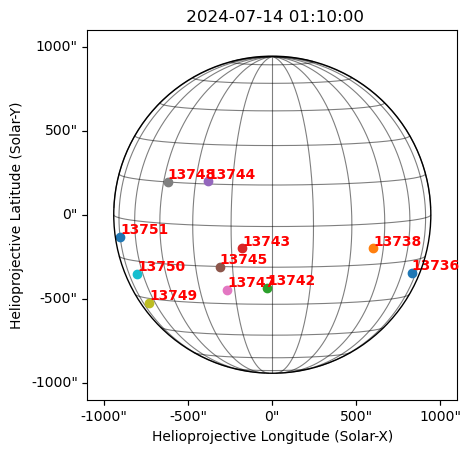

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection=blank_map)
blank_map.plot(axes=ax)
blank_map.draw_limb(axes=ax, color="k")
blank_map.draw_grid(axes=ax, color="k")

    
for region in srs_table[srs_table['ID']=='I']:
    ax.plot_coord(
        SkyCoord(region['Longitude'],
                 region['Latitude'], 
                 obstime=date_obs, 
                 observer='earth', 
                 frame=frames.HeliographicStonyhurst,
                 ).transform_to(blank_map.coordinate_frame), 'o')
    
    ax.annotate( region['Number'],
                (region['Longitude'].value, region['Latitude'].value),
                xycoords=ax.get_transform('heliographic_stonyhurst'),
                color='red',
                fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom')